In [256]:
import pickle
import os
import pandas as pd
from matplotlib import pyplot as plt
os.chdir(os.path.expanduser('~/wcEcoli/'))
# noinspection PyUnresolvedReferences
import numpy as np
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import os
from wholecell.utils.filepath import ROOT_PATH
import pickle
import os
from matplotlib import pyplot as plt
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import seaborn as sns
import glob
import plotly.express as px

In [257]:
# generate a dataframe with relevant information:
# Name the sequences to use:
current_sequence = "Clim4_STD_ratio_threshold_2_keep_NaNs"
CLNE_sequence = "CLNE3"
branch_name = "pd-half-life-debug"

In [258]:
# Read in the half life data from the output of models/ecoli/analysis/parca/protein_half_lives.py:
clim_df = f"out/{current_sequence}/kb_plot_out/protein_half_lives.tsv"
clim_df = pd.read_csv(clim_df, sep='\t')
CLNE_df = f"out/{CLNE_sequence}/kb_plot_out/protein_half_lives.tsv"
CLNE_df = pd.read_csv(CLNE_df, sep='\t')

# merge the HL data frames together:
CLNE_HL_column_new_name = f"{CLNE_sequence} HL value"
CLNE_df = CLNE_df.rename(columns={"half_life_(min)": CLNE_HL_column_new_name})
CLNE_HL_source_new_name = f"{CLNE_sequence} HL source"
CLNE_df = CLNE_df.rename(columns={"degradation_rate_source": CLNE_HL_source_new_name})
clim_df = clim_df.merge(CLNE_df[['monomer_id', CLNE_HL_column_new_name, CLNE_HL_source_new_name]], on='monomer_id', how='left')


# Load in the log average counts data generated from the output of cohort/save_cohort_average_monomer_counts.py:
clim_log_data = pd.read_csv(f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data = pd.read_csv(f'out/{CLNE_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')

# Remove the last three characters from each entry in the Monomer ID column:
clim_log_data['Monomer ID'] = clim_log_data['Monomer ID'].str[:-3]
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# rename the Log10 Average Monomer Counts column to include the sequence name:
CLNE_new_name = "Log10 " + CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"
clim_log_data = clim_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})

# Merge the long dataframes together:
clim_log_data = clim_log_data.set_index("Monomer ID")
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
combined_log_data = CLNE_log_data.join(clim_log_data, how="inner")
combined_log_data = combined_log_data.reset_index()

# Merge this data with the clim_df to get the protease assignments:
combined_log_data = combined_log_data.rename(columns={"Monomer ID": "monomer_id"})
clim_df = clim_df.merge(combined_log_data, on='monomer_id', how='left')
clim_df = clim_df.rename(columns={"degradation_rate_source": "half_life_source"})

# calculate the fold change between the log counts of CLNE and CLClim3NE:
clim_df['protein_fold_change'] = 10**(clim_df[CLClimNE_new_name]) / 10**(clim_df[CLNE_new_name])
# calculate the log2 fold change between the log counts of CLNE and CLClim3NE:
clim_df['protein_log2_fold_change'] = np.log2(clim_df['protein_fold_change'])
# calculate the log10 fold change between the log counts of CLNE and CLClim3NE:
clim_df['protein_log10_fold_change'] = np.log10(clim_df['protein_fold_change'])

# add HL fold changes too: 
clim_df['HL_fold_change'] = clim_df['half_life_(min)'] / clim_df[CLNE_HL_column_new_name]
# calculate the log2 fold change between the HL values of CLNE and CLClim3NE:
clim_df['HL_log2_fold_change'] = np.log2(clim_df['HL_fold_change'])
# calculate the log10 fold change between the HL values of CLNE and CLClim3NE:  
clim_df['HL_log10_fold_change'] = np.log10(clim_df['HL_fold_change'])


clim_df

,monomer_id,common_name,degradation_rate(1/s),half_life_(min),half_life_source,protease_assignment,ClpP_fraction,Lon_fraction,HslV_fraction,CLNE3 HL value,CLNE3 HL source,Log10 CLNE3 Average Monomer Counts,Log10 Clim4_STD_ratio_threshold_2_keep_NaNs Average Monomer Counts,protein_fold_change,protein_log2_fold_change,protein_log10_fold_change,HL_fold_change,HL_log2_fold_change,HL_log10_fold_change
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,plsC,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.249742,2.251999,1.005211,0.007498,0.002257,1.000000,0.000000,0.000000
1,1-PFK-MONOMER,fruK,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.958683,1.916220,0.906854,-0.141058,-0.042463,1.000000,0.000000,0.000000
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,panE,0.000027,432.820802,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.166982,2.235185,1.170046,0.226566,0.068203,0.721368,-0.471193,-0.141843
3,2-ISOPROPYLMALATESYN-MONOMER,leuA,0.000021,545.536619,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,3.652449,3.563799,0.815361,-0.294489,-0.088650,0.909228,-0.137286,-0.041327
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,ubiE,0.000009,1343.256864,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.673989,2.554319,0.759154,-0.397535,-0.119670,2.238761,1.162701,0.350008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,ytfR,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.282915,1.581673,1.989564,0.992452,0.298758,1.000000,0.000000,0.000000
4305,YTFT-MONOMER,ytfT,0.000006,2083.445324,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.298818,1.553161,1.796151,0.844908,0.254343,3.472409,1.795937,0.540631
4306,ZNUA-MONOMER,znuA,0.000005,2225.002167,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.829617,2.851287,1.051164,0.071988,0.021671,3.708337,1.890772,0.569179
4307,ZNUB-MONOMER,znuB,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.797419,1.795018,0.994488,-0.007974,-0.002401,1.000000,0.000000,0.000000


In [259]:
clim_combined_df = clim_df.copy()

# figure out which proteins were assigned to lon in the model:
lon_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'Lon only']

# figure out which proteins were assigned to clp in the model:
clp_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'ClpP only']

hslv_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'HslV only']

# figure out which proteins are additive in the model:
additive_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'Additive: ClpP, Lon']

# figure out which proteins are redundant in the model:
redundant_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'Additive: ClpP, Lon, HslV']

# figure out which proteins were not assigned to a protease in the model:
no_protease_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'NA']

# todo: note that these numbers will not add up to those in the graph below bc some proteins in the 2025 model are not in the 2020 model
#298 total
print("Lon Proteins(" +str(len(lon_proteins))+"): ", list(lon_proteins['common_name'])) #14
print("ClpP Proteins(" +str(len(clp_proteins))+"): ", list(clp_proteins['common_name'])) #63
print("HslV Proteins(" +str(len(hslv_proteins))+"): ", list(hslv_proteins['common_name'])) #1
print("Additive Proteins: Lon, ClpP (" +str(len(additive_proteins))+"): ", list(additive_proteins['common_name'])) #79
print("Additive: Lon, ClpP, HslV Proteins(" +str(len(redundant_proteins))+"): ", list(redundant_proteins['common_name'])) 

Lon Proteins(6):  ['ydcI', 'nemA', 'fhlA', 'metR', 'trxC', 'rpoD']
ClpP Proteins(40):  ['fadE', 'glpD', 'cysD', 'ribB', 'clpA', 'clpX', 'dksA', 'dnaB', 'dnaK', 'ftsZ', 'mukB', 'mutS', 'nfo', 'parC', 'pcnB', 'recA', 'rpsA', 'sbcC', 'uvrD', 'dps', 'def', 'phoH', 'intA', 'rutA', 'comR', 'ydhQ', 'yfcZ', 'patA', 'obgE', 'yheO', 'lldD', 'mdlB', 'oxyR', 'exuR', 'putA', 'rpoB', 'rpoC', 'rpoS', 'yheS', 'znuC']
HslV Proteins(1):  ['uhpA']
Additive Proteins: Lon, ClpP (3):  ['ibpA', 'grcA', 'dnaA']
Additive: Lon, ClpP, HslV Proteins(32):  ['aroK', 'helD', 'ligA', 'minE', 'parE', 'pspA', 'rhlB', 'srmB', 'ybaB', 'yibA', 'mazF', 'yjgA', 'yihD', 'yiiQ', 'yiaU', 'yfhH', 'erpA', 'ppiC', 'glaR', 'chaB', 'rarA', 'proQ', 'acpP', 'ycaR', 'hprR', 'murQ', 'iscR', 'kbp', 'yggX', 'glnD', 'yaeP', 'thiL']


In [260]:
clim_combined_df

,monomer_id,common_name,degradation_rate(1/s),half_life_(min),half_life_source,protease_assignment,ClpP_fraction,Lon_fraction,HslV_fraction,CLNE3 HL value,CLNE3 HL source,Log10 CLNE3 Average Monomer Counts,Log10 Clim4_STD_ratio_threshold_2_keep_NaNs Average Monomer Counts,protein_fold_change,protein_log2_fold_change,protein_log10_fold_change,HL_fold_change,HL_log2_fold_change,HL_log10_fold_change
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,plsC,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.249742,2.251999,1.005211,0.007498,0.002257,1.000000,0.000000,0.000000
1,1-PFK-MONOMER,fruK,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.958683,1.916220,0.906854,-0.141058,-0.042463,1.000000,0.000000,0.000000
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,panE,0.000027,432.820802,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.166982,2.235185,1.170046,0.226566,0.068203,0.721368,-0.471193,-0.141843
3,2-ISOPROPYLMALATESYN-MONOMER,leuA,0.000021,545.536619,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,3.652449,3.563799,0.815361,-0.294489,-0.088650,0.909228,-0.137286,-0.041327
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,ubiE,0.000009,1343.256864,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.673989,2.554319,0.759154,-0.397535,-0.119670,2.238761,1.162701,0.350008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,ytfR,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.282915,1.581673,1.989564,0.992452,0.298758,1.000000,0.000000,0.000000
4305,YTFT-MONOMER,ytfT,0.000006,2083.445324,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.298818,1.553161,1.796151,0.844908,0.254343,3.472409,1.795937,0.540631
4306,ZNUA-MONOMER,znuA,0.000005,2225.002167,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,N_end_rule,2.829617,2.851287,1.051164,0.071988,0.021671,3.708337,1.890772,0.569179
4307,ZNUB-MONOMER,znuB,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,N_end_rule,1.797419,1.795018,0.994488,-0.007974,-0.002401,1.000000,0.000000,0.000000


In [261]:
# prepare the data for a plot:
CLNE_CLClimNE_log_data_proteases = clim_combined_df.copy()

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_Lon_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Clp_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_HslV_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LC = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LCH = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_no_protease_proteases = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_log_data_with_Lon_proteases = CLClimNE_log_data_with_Lon_proteases[CLClimNE_log_data_with_Lon_proteases['protease_assignment'] == 'Lon only']
CLClimNE_log_data_with_Clp_proteases = CLClimNE_log_data_with_Clp_proteases[CLClimNE_log_data_with_Clp_proteases['protease_assignment'] == 'ClpP only']
CLClimNE_log_data_with_HslV_proteases = CLClimNE_log_data_with_HslV_proteases[CLClimNE_log_data_with_HslV_proteases['protease_assignment'] == 'HslV only']
CLClimNE_log_data_with_Additive_LC_proteases = CLClimNE_log_data_with_Additive_LC[CLClimNE_log_data_with_Additive_LC['protease_assignment'] == 'Additive: ClpP, Lon']
CLClimNE_log_data_with_Additive_LCH_proteases = CLClimNE_log_data_with_Additive_LCH[CLClimNE_log_data_with_Additive_LCH['protease_assignment'] == 'Additive: ClpP, Lon, HslV']
CLClimNE_log_data_with_no_protease_proteases = CLClimNE_log_data_with_no_protease_proteases[CLClimNE_log_data_with_no_protease_proteases['protease_assignment'] == 'NA']


In [262]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data to ? and how do I get the plot to be an exact square? and the figure title centered?
def CLNE_CLClimNE_plot_protease(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    #hovertext = {dataframe["gene symbol"],dataframe["HL value"],dataframe["HL source"]}
    hovertext = dataframe.apply(lambda row: f"Common Name: {row['common_name']}<br>Monomer ID: {row['monomer_id']}<br>HL Value (min): {row['half_life_(min)']}<br>HL Source: {row['half_life_source']}", axis=1)

 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"No Protease ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=3, opacity=.3)))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Additive: ClpP, Lon ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=5, opacity=.9)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Additive: ClpP, Lon, HslV ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Lon ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"ClpP ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Hslv ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_no_protease_proteases,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Additive_LCH_proteases,CLNE_new_name, CLClimNE_new_name, 2)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Additive_LC_proteases,CLNE_new_name, CLClimNE_new_name, 1)

CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Lon_proteases,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_Clp_proteases,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_protease(fig, CLClimNE_log_data_with_HslV_proteases,CLNE_new_name, CLClimNE_new_name, 6)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"))

# Update layout
fig.update_layout(
    title=f"Protein count comparison between the 2025 model ({current_sequence})<br>plotted against the 2020 model ({CLNE_sequence})",
    xaxis_title=f"log10(2020 model total monomer counts)",
    yaxis_title=f"log10(2025 model total monomer counts)",
    autosize=False,
    width=900,
    height=800,
    plot_bgcolor='white',
    showlegend=True,
    legend_title="Protease Assignments")


# wont open in pycharm, so save as a html:
out_pth =f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_{current_sequence}_vs_{CLNE_sequence}.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  
fig.write_html(out_pth, auto_open=True) 

# Organize proteins by their degradation rate value

In [263]:
# change the name of the HL column: 
CLNE_CLClimNE_log_data_proteases = clim_combined_df.copy()
CLNE_CLClimNE_log_data_proteases = CLNE_CLClimNE_log_data_proteases.rename(columns={"half_life_(min)": "HL value"})

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_25_below = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_25_50 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_50_75 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_75_100 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_100_125 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_125_150 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_150_175 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_175_200 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_200_300 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_300_400 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_400_500 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_500_600 = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_600 = CLNE_CLClimNE_log_data_proteases.copy()

# filter the data by the degradation rate:
CLClimNE_log_data_with_25_below = CLClimNE_log_data_with_25_below[CLClimNE_log_data_with_25_below['HL value'] <= 25]
CLClimNE_log_data_with_25_50 = CLClimNE_log_data_with_25_50[(CLClimNE_log_data_with_25_50['HL value'] > 25) & (CLClimNE_log_data_with_25_50['HL value'] <= 50)]
CLClimNE_log_data_with_50_75 = CLClimNE_log_data_with_50_75[(CLClimNE_log_data_with_50_75['HL value'] > 50) & (CLClimNE_log_data_with_50_75['HL value'] <= 75)]
CLClimNE_log_data_with_75_100 = CLClimNE_log_data_with_75_100[(CLClimNE_log_data_with_75_100['HL value'] > 75) & (CLClimNE_log_data_with_75_100['HL value'] <= 100)]
CLClimNE_log_data_with_100_125 = CLClimNE_log_data_with_100_125[(CLClimNE_log_data_with_100_125['HL value'] > 100) & (CLClimNE_log_data_with_100_125['HL value'] <= 125)]
CLClimNE_log_data_with_125_150 = CLClimNE_log_data_with_125_150[(CLClimNE_log_data_with_125_150['HL value'] > 125) & (CLClimNE_log_data_with_125_150['HL value'] <= 150)]
CLClimNE_log_data_with_150_175 = CLClimNE_log_data_with_150_175[(CLClimNE_log_data_with_150_175['HL value'] > 150) & (CLClimNE_log_data_with_150_175['HL value'] <= 175)]
CLClimNE_log_data_with_175_200 = CLClimNE_log_data_with_175_200[(CLClimNE_log_data_with_175_200['HL value'] > 175) & (CLClimNE_log_data_with_175_200['HL value'] <= 200)]
CLClimNE_log_data_with_200_300 = CLClimNE_log_data_with_200_300[(CLClimNE_log_data_with_200_300['HL value'] > 200) & (CLClimNE_log_data_with_200_300['HL value'] <= 300)]
CLClimNE_log_data_with_300_400 = CLClimNE_log_data_with_300_400[(CLClimNE_log_data_with_300_400['HL value'] > 300) & (CLClimNE_log_data_with_300_400['HL value'] <= 400)]
CLClimNE_log_data_with_400_500 = CLClimNE_log_data_with_400_500[(CLClimNE_log_data_with_400_500['HL value'] > 400) & (CLClimNE_log_data_with_400_500['HL value'] <= 500)]
CLClimNE_log_data_with_500_600 = CLClimNE_log_data_with_500_600[(CLClimNE_log_data_with_500_600['HL value'] > 500) & (CLClimNE_log_data_with_500_600['HL value'] <= 600)]
CLClimNE_log_data_with_600 = CLClimNE_log_data_with_600[CLClimNE_log_data_with_600['HL value'] > 600]



In [264]:
## Create scatter plot of CLNE counts to CLClim0NE counts, but color the protiens based on their protease assignment in the CLClim0NE model
# create the plot!
# TODO: do I need to normalize the data too ? and how do I get the plot to be an exact square? and the figure title centered?
def CLNE_CLClimNE_plot_by_half_life(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    #hovertext = {dataframe["gene symbol"],dataframe["HL value"],dataframe["HL source"]}
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['monomer_id']}<br> Common Name: {row['common_name']}<br>HL Value: {row['HL value']}<br>HL Source: {row['half_life_source']}<br>protease assignment: {row['protease_assignment']}<br>2020 model AMC: {10**(row[CLNE_new_name] +1)}<br>2025 model AMC: {10**(row[CLClimNE_new_name]+1)}", axis=1)

 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='grey', size=3, opacity=.3)))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=4, opacity=.7)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))
        
    elif protease == 7: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lawngreen', size=5, opacity=.9)))
        
    elif protease == 11: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 12: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: ({np.shape(dataframe)[0]})", marker=dict(color='darkorange', size=5, opacity=.9)))
        
    elif protease == 13: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: ({np.shape(dataframe)[0]})", marker=dict(color='red', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"))

# Update layout
fig.update_layout(
    title=f"Protein count comparison between the 2025 model ({current_sequence})<br>plotted against the 2020 model ({CLNE_sequence})",
    xaxis_title=f"log10(2020 model total monomer counts)",
    yaxis_title=f"log10(2025 model total monomer counts)",
    autosize=False,
    width=900,
    height=800, 
    showlegend=True,
    plot_bgcolor='white',
    legend_title="Half Life Value Range")


# wont open in pycharm, so save as a html:
out_pth = f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_colored_by_HL_value_{current_sequence}_vs_{CLNE_sequence}.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 


# Gather complex data 

monomers in zero complexes

In [265]:
# note something weird is going on here where the complexes have non-zero values? # todo: have the equilibrium complexes read in as well! 
monomers_in_zero_complexes_in_complexes_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_zero_complexes/above_complex_threshold_0.csv'
monomers_in_zero_complexes_free_monomers_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_zero_complexes/above_free_threshold_-1.csv'

# read in the tables
monomers_in_zero_complexes_in_complexes = pd.read_csv(monomers_in_zero_complexes_in_complexes_pth)
monomers_in_zero_complexes_free_monomers = pd.read_csv(monomers_in_zero_complexes_free_monomers_pth)

# add a column called complex type to the monomers_in_zero_complexes_in_complexes dataframe and assign all values to "zero_in_complexes":
monomers_in_zero_complexes_in_complexes['complex type'] = "zero (but shows up in complexes?)"
monomers_in_zero_complexes_in_complexes = monomers_in_zero_complexes_in_complexes[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]
monomers_in_zero_complexes_in_complexes

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,ARCA-MONOMER,NaN,zero (but shows up in complexes?),2948.021801,2941.790280,6.231521,0.997886,0.002114
1,BASR-MONOMER,NaN,zero (but shows up in complexes?),205.006014,6.864730,198.141284,0.033486,0.966514
2,BASS-MONOMER,NaN,zero (but shows up in complexes?),100.098361,0.019110,100.079251,0.000191,0.999809
3,EG10239-MONOMER,NaN,zero (but shows up in complexes?),32.339218,30.785091,1.554127,0.951943,0.048057
4,EG11088-MONOMER,NaN,zero (but shows up in complexes?),209.740518,0.099403,209.641115,0.000474,0.999526
5,EG11149-MONOMER,NaN,zero (but shows up in complexes?),380.163740,0.664104,379.499636,0.001747,0.998253
6,G6812-MONOMER,NaN,zero (but shows up in complexes?),47.201014,0.263435,46.937579,0.005581,0.994419
7,G7071-MONOMER,NaN,zero (but shows up in complexes?),275.855030,36.204797,239.650233,0.131246,0.868754
8,G7133-MONOMER,NaN,zero (but shows up in complexes?),80.004001,15.195024,64.808978,0.189928,0.810072
9,G7244-MONOMER,NaN,zero (but shows up in complexes?),73.629426,0.032253,73.597172,0.000438,0.999562


In [266]:
# add a column called complex type to the monomers_in_zero_complexes_in_complexes dataframe and assign all values to "zero_in_complexes":
monomers_in_zero_complexes_free_monomers['complex type'] = "zero"
# remove columns that are not needed:
monomers_in_zero_complexes_free_monomers = monomers_in_zero_complexes_free_monomers[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]

# need to take the overlap out of the monomers_in_zero_complexes_free_monomers dataframe:
monomers_in_zero_complexes_free_monomers = monomers_in_zero_complexes_free_monomers[~monomers_in_zero_complexes_free_monomers['Monomer ID'].isin(monomers_in_zero_complexes_in_complexes['Monomer ID'])]
monomers_in_zero_complexes_free_monomers

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,NaN,zero,172.650112,172.650112,0.0,1.0,0.0
1,2-DEHYDROPANTOATE-REDUCT-MONOMER,NaN,zero,208.794330,208.794330,0.0,1.0,0.0
2,2-ISOPROPYLMALATESYN-MONOMER,NaN,zero,3039.741973,3039.741973,0.0,1.0,0.0
3,2-OCTAPRENYLPHENOL-HYDROX-MONOMER,NaN,zero,76.153749,76.153749,0.0,1.0,0.0
4,4OHBENZOATE-OCTAPRENYLTRANSFER-MONOMER,NaN,zero,33.441483,33.441483,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
2777,YJJK-MONOMER,NaN,zero,1430.327942,1430.327942,0.0,1.0,0.0
2778,YNFJ-MONOMER,NaN,zero,1.740930,1.740930,0.0,1.0,0.0
2779,YOJI-MONOMER,NaN,zero,103.352168,103.352168,0.0,1.0,0.0
2780,YPHC-MONOMER,NaN,zero,50.649505,50.649505,0.0,1.0,0.0


monomers in a single complex

In [267]:
# Note: i set the fraction to -1 in order to get all the monomers (and wouldn't have to sift through the confusing double shows)
monomers_in_one_complex_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_one_complex/above_complex_threshold_-1.csv'

# read in the tables
monomers_in_one_complex = pd.read_csv(monomers_in_one_complex_pth)
monomers_in_one_complex['complex type'] = "one"
monomers_in_one_complex = monomers_in_one_complex[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]

monomers_in_one_complex

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,1-PFK-MONOMER,1-PFK,one,54.924217,0.517824,54.406392,0.009428,0.990572
1,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,CPLX0-8301,one,495.154574,399.410564,95.744010,0.806638,0.193362
2,3-CH3-2-OXOBUTANOATE-OH-CH3-XFER-MONOMER,3-METHYL-2-OXOBUT-OHCH3XFER-CPLX,one,3410.863420,5.426181,3405.437239,0.001591,0.998409
3,3-ISOPROPYLMALDEHYDROG-MONOMER,3-ISOPROPYLMALDEHYDROG-CPLX,one,3948.284848,1.360413,3946.924435,0.000345,0.999655
4,3-OXOACYL-ACP-REDUCT-MONOMER,CPLX0-8005,one,4622.621544,2.445388,4620.176157,0.000529,0.999471
...,...,...,...,...,...,...,...,...
1354,YTFR-MONOMER,ABC-46-CPLX,one,14.164298,2.130420,12.033878,0.150408,0.849592
1355,YTFT-MONOMER,ABC-46-CPLX,one,12.770516,0.736638,12.033878,0.057683,0.942317
1356,ZNUA-MONOMER,ABC-63-CPLX,one,744.140630,711.039941,33.100689,0.955518,0.044482
1357,ZNUB-MONOMER,ABC-63-CPLX,one,66.552309,0.350931,66.201377,0.005273,0.994727


monomers in multiple complexes

In [268]:
# Note: i set the fraction to -1 in order to get all the monomers (and wouldn't have to sift through the confusing double shows)
monomers_in_multiple_complexes_pth = 'out/CLClim3NE1/wildtype_000000/plotOut/complex_classifications_preParca/monomers_in_multiple_complexes/above_complex_threshold_-1.csv'

# read in the tables
monomers_in_multiple_complexes_pre = pd.read_csv(monomers_in_multiple_complexes_pth)
monomers_in_multiple_complexes_pre['complex type'] = "multiple"
monomers_in_multiple_complexes_pre = monomers_in_multiple_complexes_pre[['Monomer ID', 'complex_id', 'complex type', 'Total Counts', 'Free Counts', 'Complex Counts', 'Free Fraction', 'Complex Fraction']]
monomers_in_multiple_complexes_pre

,Monomer ID,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,ACSERLYA-MONOMER,ACSERLYA-CPLX,multiple,19594.806116,4.481933,19590.324183,0.000229,0.999771
1,ACSERLYA-MONOMER,CYSSYNMULTI-CPLX,multiple,19594.806116,4.481933,19590.324183,0.000229,0.999771
2,ALPHACOMP-MONOMER,CPLX0-7841,multiple,1105.079833,3.736153,1101.343680,0.003381,0.996619
3,ALPHACOMP-MONOMER,SULFITE-REDUCT-CPLX,multiple,1105.079833,3.736153,1101.343680,0.003381,0.996619
4,ARTM-MONOMER,ABC-4-CPLX,multiple,74.330342,2.890436,71.439907,0.038886,0.961114
...,...,...,...,...,...,...,...,...
383,SERINE-O-ACETTRAN-MONOMER,CYSSYNMULTI-CPLX,multiple,207.662261,2.184378,205.477883,0.010519,0.989481
384,TORS-MONOMER,CPLX0-11302,multiple,13.978077,0.017897,13.960180,0.001280,0.998720
385,TORS-MONOMER,TORS-CPLX,multiple,13.978077,0.017897,13.960180,0.001280,0.998720
386,TRYPSYN-BPROTEIN,CPLX0-2401,multiple,1852.089412,0.857527,1851.231885,0.000463,0.999537


In [269]:
# using this: https://stackoverflow.com/questions/25264798/checking-for-and-indexing-non-unique-duplicate-values-in-a-numpy-array
# find the monmers that show up more than once in the dataframe monomers_in_multiple_complexes:
#monomer_ids = monomers_in_multiple_complexes['Monomer ID']
unq, unq_idx, unq_cnt = np.unique(monomers_in_multiple_complexes_pre['Monomer ID'], return_inverse=True, return_counts=True)
print(len(unq)) #169
print(len(unq_cnt))


cnt_mask = unq_cnt > 1
dup_ids = unq[cnt_mask]
len(dup_ids)

cnt_idx, = np.nonzero(cnt_mask)
idx_mask = np.in1d(unq_idx, cnt_idx)
idx_idx, = np.nonzero(idx_mask)
srt_idx = np.argsort(unq_idx[idx_mask])
dup_idx = np.split(idx_idx[srt_idx], np.cumsum(unq_cnt[cnt_mask])[:-1])

169
169


In [270]:
# for each monomer that shows up more than once in the monomers_in_multiple_complexes, find the complex id 
unique_monomer_ids = monomers_in_multiple_complexes_pre['Monomer ID'].unique()
unique_monomer_ids_corresponding_complex_ids = []
for monomer_id in unique_monomer_ids:
    complex_ids = monomers_in_multiple_complexes_pre[monomers_in_multiple_complexes_pre['Monomer ID'] == monomer_id]['complex_id'].unique()
    unique_monomer_ids_corresponding_complex_ids.append(complex_ids)

# drop the complex id row in the monomers_in_multiple_complexes dataframe:
monomers_in_multiple_complexes = monomers_in_multiple_complexes_pre.drop(columns=['complex_id'])
# remove rows that are duplicates from the monomers_in_multiple_complexes dataframe:
monomers_in_multiple_complexes = monomers_in_multiple_complexes.drop_duplicates(subset=['Monomer ID'], keep='first')

# make a dictionary of the monomer ids and their corresponding complex ids:
monomer_ids_complex_ids_dict = {}
for i in range(len(unique_monomer_ids)):
    monomer_ids_complex_ids_dict[unique_monomer_ids[i]] = unique_monomer_ids_corresponding_complex_ids[i]
monomer_ids_complex_ids_dict

# make a new row for the complex type in the monomers_in_multiple_complexes dataframe:
monomers_in_multiple_complexes['complex_id'] = monomers_in_multiple_complexes['Monomer ID'].map(monomer_ids_complex_ids_dict)

monomers_in_multiple_complexes

,Monomer ID,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction,complex_id
0,ACSERLYA-MONOMER,multiple,19594.806116,4.481933,19590.324183,0.000229,0.999771,"[ACSERLYA-CPLX, CYSSYNMULTI-CPLX]"
2,ALPHACOMP-MONOMER,multiple,1105.079833,3.736153,1101.343680,0.003381,0.996619,"[CPLX0-7841, SULFITE-REDUCT-CPLX]"
4,ARTM-MONOMER,multiple,74.330342,2.890436,71.439907,0.038886,0.961114,"[ABC-4-CPLX, CPLX0-8120]"
6,ARTP-MONOMER,multiple,185.099258,42.219444,142.879814,0.228091,0.771909,"[ABC-4-CPLX, CPLX0-8120]"
8,ARTQ-MONOMER,multiple,72.323795,0.883888,71.439907,0.012221,0.987779,"[ABC-4-CPLX, CPLX0-8120]"
...,...,...,...,...,...,...,...,...
378,SECG,multiple,1618.075735,1262.375958,355.699777,0.780171,0.219829,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]"
380,SECY,multiple,355.768649,0.068872,355.699777,0.000194,0.999806,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]"
382,SERINE-O-ACETTRAN-MONOMER,multiple,207.662261,2.184378,205.477883,0.010519,0.989481,"[CPLX0-237, CYSSYNMULTI-CPLX]"
384,TORS-MONOMER,multiple,13.978077,0.017897,13.960180,0.001280,0.998720,"[CPLX0-11302, TORS-CPLX]"


merge all datasets together

In [271]:
# concatenate the dataframes together:
merged_complex_dataframe = pd.concat([monomers_in_zero_complexes_in_complexes, monomers_in_zero_complexes_free_monomers], ignore_index=True)
merged_complex_dataframe = pd.concat([merged_complex_dataframe, monomers_in_one_complex], ignore_index=True)
merged_complex_dataframe = pd.concat([merged_complex_dataframe, monomers_in_multiple_complexes], ignore_index=True)

# if there is no complex id, set it to "NA"
merged_complex_dataframe['complex_id'] = merged_complex_dataframe['complex_id'].fillna("NA")
merged_complex_dataframe = merged_complex_dataframe.rename(columns={"Monomer ID": "monomer_id"})

merged_complex_dataframe


,monomer_id,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,ARCA-MONOMER,NA,zero (but shows up in complexes?),2948.021801,2941.790280,6.231521,0.997886,0.002114
1,BASR-MONOMER,NA,zero (but shows up in complexes?),205.006014,6.864730,198.141284,0.033486,0.966514
2,BASS-MONOMER,NA,zero (but shows up in complexes?),100.098361,0.019110,100.079251,0.000191,0.999809
3,EG10239-MONOMER,NA,zero (but shows up in complexes?),32.339218,30.785091,1.554127,0.951943,0.048057
4,EG11088-MONOMER,NA,zero (but shows up in complexes?),209.740518,0.099403,209.641115,0.000474,0.999526
...,...,...,...,...,...,...,...,...
4305,SECG,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]",multiple,1618.075735,1262.375958,355.699777,0.780171,0.219829
4306,SECY,"[SEC-SECRETION-CPLX, SECE-G-Y-CPLX]",multiple,355.768649,0.068872,355.699777,0.000194,0.999806
4307,SERINE-O-ACETTRAN-MONOMER,"[CPLX0-237, CYSSYNMULTI-CPLX]",multiple,207.662261,2.184378,205.477883,0.010519,0.989481
4308,TORS-MONOMER,"[CPLX0-11302, TORS-CPLX]",multiple,13.978077,0.017897,13.960180,0.001280,0.998720


merge with the CLNE_CLClimNE_log_data_proteases dataframe

In [272]:
# merge the merged_complex_dataframe with the CLClimNE_log_data_with_proteases dataframe:
CLNE_CLClimNE_log_data_proteases_with_complexes = pd.merge(CLNE_CLClimNE_log_data_proteases, merged_complex_dataframe, on='monomer_id', how='left')



# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_25_below = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_25_50 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_50_75 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_75_100 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_100_125 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_125_150 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_150_175 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_175_200 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_200_300 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_300_400 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_400_500 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_500_600 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_log_data_with_600 = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()

# filter the data by the degradation rate:
CLClimNE_log_data_with_25_below = CLClimNE_log_data_with_25_below[CLClimNE_log_data_with_25_below['HL value'] <= 25]
CLClimNE_log_data_with_25_50 = CLClimNE_log_data_with_25_50[(CLClimNE_log_data_with_25_50['HL value'] > 25) & (CLClimNE_log_data_with_25_50['HL value'] <= 50)]
CLClimNE_log_data_with_50_75 = CLClimNE_log_data_with_50_75[(CLClimNE_log_data_with_50_75['HL value'] > 50) & (CLClimNE_log_data_with_50_75['HL value'] <= 75)]
CLClimNE_log_data_with_75_100 = CLClimNE_log_data_with_75_100[(CLClimNE_log_data_with_75_100['HL value'] > 75) & (CLClimNE_log_data_with_75_100['HL value'] <= 100)]
CLClimNE_log_data_with_100_125 = CLClimNE_log_data_with_100_125[(CLClimNE_log_data_with_100_125['HL value'] > 100) & (CLClimNE_log_data_with_100_125['HL value'] <= 125)]
CLClimNE_log_data_with_125_150 = CLClimNE_log_data_with_125_150[(CLClimNE_log_data_with_125_150['HL value'] > 125) & (CLClimNE_log_data_with_125_150['HL value'] <= 150)]
CLClimNE_log_data_with_150_175 = CLClimNE_log_data_with_150_175[(CLClimNE_log_data_with_150_175['HL value'] > 150) & (CLClimNE_log_data_with_150_175['HL value'] <= 175)]
CLClimNE_log_data_with_175_200 = CLClimNE_log_data_with_175_200[(CLClimNE_log_data_with_175_200['HL value'] > 175) & (CLClimNE_log_data_with_175_200['HL value'] <= 200)]
CLClimNE_log_data_with_200_300 = CLClimNE_log_data_with_200_300[(CLClimNE_log_data_with_200_300['HL value'] > 200) & (CLClimNE_log_data_with_200_300['HL value'] <= 300)]
CLClimNE_log_data_with_300_400 = CLClimNE_log_data_with_300_400[(CLClimNE_log_data_with_300_400['HL value'] > 300) & (CLClimNE_log_data_with_300_400['HL value'] <= 400)]
CLClimNE_log_data_with_400_500 = CLClimNE_log_data_with_400_500[(CLClimNE_log_data_with_400_500['HL value'] > 400) & (CLClimNE_log_data_with_400_500['HL value'] <= 500)]
CLClimNE_log_data_with_500_600 = CLClimNE_log_data_with_500_600[(CLClimNE_log_data_with_500_600['HL value'] > 500) & (CLClimNE_log_data_with_500_600['HL value'] <= 600)]
CLClimNE_log_data_with_600 = CLClimNE_log_data_with_600[CLClimNE_log_data_with_600['HL value'] > 600]



Generate a plot with the complexes plotted by type

In [273]:
## Plot where the complex type is highlighted by shape and half life by color
def CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['monomer_id']}<br> Common Name: {row['common_name']}<br>HL Value: {row['HL value']}<br>HL Source: {row['half_life_source']}<br>protease assignment: {row['protease_assignment']}<br>2020 model AMC: {10**(row[CLNE_new_name] +1)}<br>2025 model AMC: {10**(row[CLClimNE_new_name]+1)}<br>Complex Classification: {row['complex type']}<br>Complex ID(s): {row['complex_id']}<br>Total Counts: {row['Total Counts']}<br>Free Counts: {row['Free Counts']} Free Fraction: {row['Free Fraction']}<br>Complexed Counts: {row['Complex Counts']} Complexed Fraction: {row['Complex Fraction']}<br>", axis=1)

 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='grey', size=3, opacity=.3)))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: ({np.shape(dataframe)[0]})", marker=dict(color='cornflowerblue', size=4, opacity=.5)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellowgreen', size=5, opacity=.9)))
        
    elif protease == 5: # clp
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: ({np.shape(dataframe)[0]})", marker=dict(color='brown', size=5, opacity=.9)))
        
    elif protease == 7: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lawngreen', size=5, opacity=.9)))
        
    elif protease == 11: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=.9)))
        
    elif protease == 12: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: ({np.shape(dataframe)[0]})", marker=dict(color='darkorange', size=5, opacity=.9)))
        
    elif protease == 13: # hslv
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: ({np.shape(dataframe)[0]})", marker=dict(color='red', size=5, opacity=.9)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"))

fig.update_layout(
    title=f"Protein count comparison between the 2025 model ({current_sequence})<br>plotted against the 2020 model ({CLNE_sequence})",
    xaxis_title=f"log10(2020 model total monomer counts)",
    yaxis_title=f"log10(2025 model total monomer counts)",
    autosize=False,
    width=900,
    height=800, 
    showlegend=True,
    plot_bgcolor='white',
    legend_title="Half Life Value Range")

# wont open in pycharm, so save as a html:
out_pth = f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_colored_by_HL_value_including_complex_data_{current_sequence}_vs_{CLNE_sequence}.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 



add the symbols too

In [274]:
## have the symbol plotted as well

# TODO: do I need to normalize the data too ? and how do I get the plot to be an exact square? and the figure title centered?


def hover_text_info(dataframe):
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['monomer_id']}<br> Common Name: {row['common_name']}<br>HL Value: {row['HL value']}<br>HL Source: {row['half_life_source']}<br>protease assignment: {row['protease_assignment']}<br>2020 model AMC: {10**(row[CLNE_new_name] +1)}<br>2025 model AMC: {10**(row[CLClimNE_new_name]+1)}<br>Complex Classification: {row['complex type']}<br>Complex ID(s): {row['complex_id']}<br>Total Counts: {row['Total Counts']}<br>Free Counts: {row['Free Counts']} Free Fraction: {row['Free Fraction']}<br>Complexed Counts: {row['Complex Counts']} Complexed Fraction: {row['Complex Fraction']}<br>", axis=1)
    return hovertext

def plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type):
    df = dataframe[dataframe['complex type'] == complex_type]
    df = df.reset_index(drop=True)
    type_number = f'{complex_type} ('+ f'{len(df)}' + ')'
    x = df[CLNE_new_name]
    y = df[CLClimNE_new_name]
    hovertext = hover_text_info(df)
    return x, y, hovertext, type_number
    

def CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, dataframe, CLNE_new_name, CLClimNE_new_name, protease=0):
    
    #symbols = dataframe['complex type'].map({
    #     'zero_in_complexes': 'circle-open',
    #     'zero_in_free_monomers': 'circle',
    #     'one': 'diamond',
    #     'multiple': 'square',
    #     'unknown': 'triangle-up'
    # })
    symbols = {
        'zero (but shows up in complexes?)': 'circle-open',
        'zero': 'circle',
        'one': 'diamond',
        'multiple': 'square',
        'unknown': 'triangle-up'
    }
 
    # Add scatter trace
    if protease == 0: # no assignement
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"> 600 mins: {type_number}", marker=dict(color='grey', size=3, opacity=.3, symbol = symbol_shape)))

    elif protease == 1: # ClpP and Lon
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)   
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"500-600 mins: {type_number}", marker=dict(color='cornflowerblue', size=4, opacity=.5, symbol = symbol_shape)))
        
    elif protease == 2: # C L H
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: {type_number}", marker=dict(color='orange', size=4, opacity=.7, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"400-500 mins: ({np.shape(dataframe)[0]})", marker=dict(color='orange', size=4, opacity=.7)))
        
    elif protease == 4: # lon
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"300-400 mins: {type_number}", marker=dict(color='yellowgreen', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 5: # clp
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: {type_number}", marker=dict(color='deeppink', size=4, opacity=.6, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"200-300 mins: ({np.shape(dataframe)[0]})", marker=dict(color='deeppink', size=4, opacity=.6)))
        
    elif protease == 6: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"175-200 mins: {type_number}", marker=dict(color='brown', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 7: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: {type_number}", marker=dict(color='lightseagreen', size=5, opacity=.9, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"150-175 mins: ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=5, opacity=.9)))
        
    elif protease == 8: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: {type_number}", marker=dict(color='yellow', size=5, opacity=.9, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"125-150 mins: ({np.shape(dataframe)[0]})", marker=dict(color='yellow', size=5, opacity=.9)))
        
    elif protease == 9: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: {type_number}", marker=dict(color='coral', size=5, opacity=.9, symbol = symbol_shape)))
        #fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"100-125 mins: ({np.shape(dataframe)[0]})", marker=dict(color='coral', size=5, opacity=.9)))
        
    elif protease == 10: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"75-100 mins: {type_number}", marker=dict(color='lawngreen', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 11: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"50-75 mins: {type_number}", marker=dict(color='orange', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 12: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"25-50 mins: {type_number}", marker=dict(color='darkorange', size=5, opacity=.9, symbol = symbol_shape)))
        
    elif protease == 13: # hslv
        for complex_type in dataframe['complex type'].unique():
            symbol_shape = symbols[complex_type]
            x, y, hovertext, type_number = plot_info(dataframe, CLNE_new_name, CLClimNE_new_name, complex_type)
            fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"< 25 mins: {type_number}", marker=dict(color='red', size=5, opacity=.9, symbol = symbol_shape)))

# now plot!

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_600,CLNE_new_name, CLClimNE_new_name, 0)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_500_600,CLNE_new_name, CLClimNE_new_name, 1)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_400_500,CLNE_new_name, CLClimNE_new_name, 2)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_300_400,CLNE_new_name, CLClimNE_new_name, 4)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_200_300,CLNE_new_name, CLClimNE_new_name, 5)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_175_200,CLNE_new_name, CLClimNE_new_name, 6)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_150_175,CLNE_new_name, CLClimNE_new_name, 7)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_125_150,CLNE_new_name, CLClimNE_new_name, 8)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_100_125,CLNE_new_name, CLClimNE_new_name, 9)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_75_100,CLNE_new_name, CLClimNE_new_name, 10)

CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_50_75,CLNE_new_name, CLClimNE_new_name, 11)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_50,CLNE_new_name, CLClimNE_new_name, 12)
CLNE_CLClimNE_plot_by_half_life_and_complex_data(fig, CLClimNE_log_data_with_25_below,CLNE_new_name, CLClimNE_new_name, 13)

# add a y=x line
fig.add_trace(go.Scatter(x=[0, 6], y=[0, 6], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"));

# Update layout
fig.update_layout(
    title=f"Protein count comparison between the 2025 model ({current_sequence})<br>plotted against the 2020 model ({CLNE_sequence})",
    xaxis_title=f"log10(2020 model total monomer counts)",
    yaxis_title=f"log10(2025 model total monomer counts)",
    autosize=False,
    width=900,
    height=600, 
    showlegend=True,
    plot_bgcolor='white',
    legend_title="Half Life Value Range")

# wont open in pycharm, so save as a html:
out_pth = f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_colored_by_HL_value_with_complex_type_indicated_{current_sequence}_vs_{CLNE_sequence}.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 

# todo: note the difference in total protein counts here could just be from the fact that the average over generation calculation was done differently for the two sources 
# todo ^ double check this 

# plot with the largest incrase and decrease in HL highlighted

In [275]:
CLNE_CLClimNE_log_data_proteases_with_complexes

,monomer_id,common_name,degradation_rate(1/s),HL value,half_life_source,protease_assignment,ClpP_fraction,Lon_fraction,HslV_fraction,CLNE3 HL value,...,HL_fold_change,HL_log2_fold_change,HL_log10_fold_change,complex_id,complex type,Total Counts,Free Counts,Complex Counts,Free Fraction,Complex Fraction
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,plsC,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,...,1.000000,0.000000,0.000000,NA,zero,172.650112,172.650112,0.000000,1.000000,0.000000
1,1-PFK-MONOMER,fruK,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,...,1.000000,0.000000,0.000000,1-PFK,one,54.924217,0.517824,54.406392,0.009428,0.990572
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,panE,0.000027,432.820802,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,...,0.721368,-0.471193,-0.141843,NA,zero,208.794330,208.794330,0.000000,1.000000,0.000000
3,2-ISOPROPYLMALATESYN-MONOMER,leuA,0.000021,545.536619,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,...,0.909228,-0.137286,-0.041327,NA,zero,3039.741973,3039.741973,0.000000,1.000000,0.000000
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,ubiE,0.000009,1343.256864,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,...,2.238761,1.162701,0.350008,CPLX0-8301,one,495.154574,399.410564,95.744010,0.806638,0.193362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,ytfR,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,...,1.000000,0.000000,0.000000,ABC-46-CPLX,one,14.164298,2.130420,12.033878,0.150408,0.849592
4305,YTFT-MONOMER,ytfT,0.000006,2083.445324,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,...,3.472409,1.795937,0.540631,ABC-46-CPLX,one,12.770516,0.736638,12.033878,0.057683,0.942317
4306,ZNUA-MONOMER,znuA,0.000005,2225.002167,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,600.0,...,3.708337,1.890772,0.569179,ABC-63-CPLX,one,744.140630,711.039941,33.100689,0.955518,0.044482
4307,ZNUB-MONOMER,znuB,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,600.0,...,1.000000,0.000000,0.000000,ABC-63-CPLX,one,66.552309,0.350931,66.201377,0.005273,0.994727


Generate plot with the largest increase and decrease in HL highlighted

In [276]:
# large increase 
fold_increase_threshold = 30
fold_decrease_threshold = .10

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_large_increase = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_large_decrease = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_remaining = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()


# extract the rows with monomer ids that match those in the CLNE1_HLs_2 list:
CLClimNE_large_increase = CLClimNE_large_increase[CLClimNE_large_increase['HL_fold_change'] >= fold_increase_threshold]
CLClimNE_large_decrease = CLClimNE_large_decrease[CLClimNE_large_decrease['HL_fold_change'] <= fold_decrease_threshold]

# make CLClimNE_remaining have the values not in either: 
CLClimNE_remaining = CLClimNE_remaining[~CLClimNE_remaining['monomer_id'].isin(CLNE_monomers_2_mins)]
CLClimNE_remaining = CLClimNE_remaining[~CLClimNE_remaining['monomer_id'].isin(CLClimNE_large_decrease['monomer_id'])]


def CLNE_CLClimNE_plot_by_fold_change(fig, dataframe, CLNE_new_name, CLClimNE_new_name, CLNE_HL_column_new_name, CLNE_HL_source_new_name, protease=0):
    x = dataframe[CLNE_new_name]
    y = dataframe[CLClimNE_new_name]
    hovertext = dataframe.apply(lambda row: f"Monomer ID: {row['monomer_id']}<br> Common Name: {row['common_name']}<br>2025 HL Value (min): {row['HL value']}<br>2025 HL Source: {row['half_life_source']}<br>2020 HL Value (min): {row[CLNE_HL_column_new_name]}<br>2020 HL Source: {row[CLNE_HL_source_new_name]}<br>protease assignment: {row['protease_assignment']}<br>2020 model AMC: {10**(row[CLNE_new_name] +1)}<br>2025 model AMC: {10**(row[CLClimNE_new_name]+1)}<br>Complex Classification: {row['complex type']}<br>Complex ID(s): {row['complex_id']}<br>Total Counts: {row['Total Counts']}<br>Free Counts: {row['Free Counts']} Free Fraction: {row['Free Fraction']}<br>Complexed Counts: {row['Complex Counts']} Complexed Fraction: {row['Complex Fraction']}<br>", axis=1)
 
    # Add scatter trace
    if protease == 0: # no assignement
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Protein Counts ({np.shape(dataframe)[0]})", marker=dict(color='lightseagreen', size=3, opacity=.5, )))

    elif protease == 1: # ClpP and Lon
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Largest increase in HL value<br> (threshold: HL fold change >= {fold_increase_threshold}, n={np.shape(dataframe)[0]})", marker=dict(color='orange', size=5, opacity=1)))
        
    elif protease == 2: # C L H
        fig.add_trace(go.Scatter(x=x, y=y, hovertext=hovertext, mode='markers', name=f"Largest decrease in HL value<br>(threshold: HL fold change <= {fold_decrease_threshold}, n={np.shape(dataframe)[0]})", marker=dict(color='red', size=5, opacity=1)))
        

# Create figure
fig = go.Figure()

# Add scatter plots and trendlines for each dataset
CLNE_CLClimNE_plot_by_fold_change(fig, CLClimNE_remaining,CLNE_new_name, CLClimNE_new_name, CLNE_HL_column_new_name, CLNE_HL_source_new_name, 0)

CLNE_CLClimNE_plot_by_fold_change(fig, CLClimNE_large_increase,CLNE_new_name, CLClimNE_new_name, CLNE_HL_column_new_name, CLNE_HL_source_new_name, 1)

CLNE_CLClimNE_plot_by_fold_change(fig, CLClimNE_large_decrease,CLNE_new_name, CLClimNE_new_name, CLNE_HL_column_new_name, CLNE_HL_source_new_name, 2)


# add a y=x line
fig.add_trace(go.Scatter(x=[0, 5.5], y=[0, 5.5], mode="lines",
    line=go.scatter.Line(color="black", dash="dash"), opacity=0.2,
    name="y=x"))

# Update layout
fig.update_layout(
    title=f"Protein count comparison between the 2025 model ({current_sequence})<br>plotted against the 2020 model ({CLNE_sequence})",
    xaxis_title=f"log10(2020 model total monomer counts)",
    yaxis_title=f"log10(2025 model total monomer counts)",
    autosize=False,
    width=900,
    height=700, 
    showlegend=True,
    plot_bgcolor='white',
    legend_title="Half Life Value Range")
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)

out_pth = f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_colored_by_fold_change_{current_sequence}_vs_{CLNE_sequence}.html"
out_pth = os.path.expanduser(out_pth) 
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
fig.write_html(out_pth, auto_open=True) # displays the figure on a default web browser 

# Bar plots 

Index(['rbsR', 'rmf', 'smg', 'adhP', 'yeaW', 'fliT', 'ygiQ', 'fliS', 'yeaC',
       'dgcP', 'ymdA', 'hcaR', 'ychA', 'fliK', 'ves', 'trhO', 'fimE', 'cutA',
       'flgK', 'flgD', 'cspD', 'ubiT', 'flgL', 'ygbJ', 'flhC', 'ilvM', 'flgJ',
       'yodC', 'ratA', 'rseA', 'flxA', 'yehE', 'prpE', 'flgC', 'patA', 'cfa',
       'pdeH', 'clpS', 'feaR', 'zupT', 'alsE', 'yjjG', 'ylaC', 'cspE', 'yoaC',
       'fis', 'fliD', 'plaP', 'rpoS', 'flgM', 'aat', 'idnR', 'glaH', 'dinJ',
       'feoB', 'yadI', 'fliC'],
      dtype='object', name='common_name')


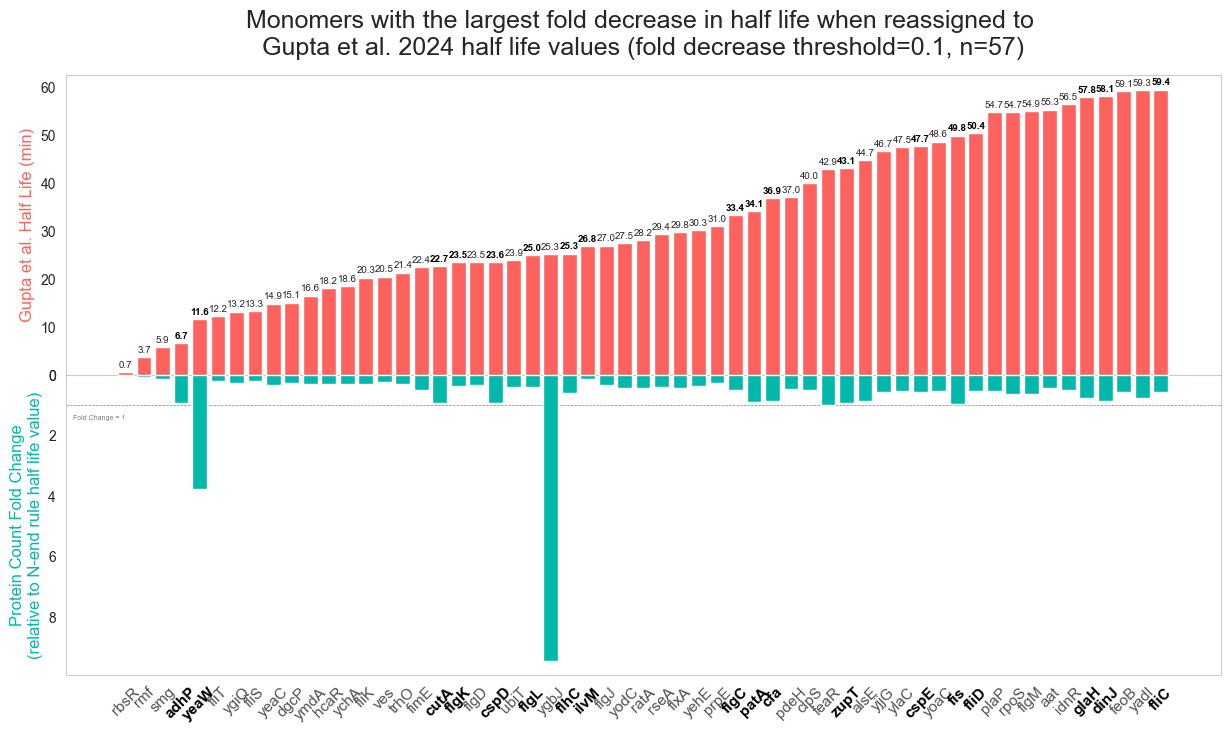

In [301]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional


# large increase 
fold_increase_threshold = 30
fold_decrease_threshold = .10

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_large_increase = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_large_decrease = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()


# extract the highest fold increase half lives:
CLClimNE_large_increase = CLClimNE_large_increase[CLClimNE_large_increase['HL_fold_change'] >= fold_increase_threshold]
CLClimNE_large_decrease = CLClimNE_large_decrease[CLClimNE_large_decrease['HL_fold_change'] <= fold_decrease_threshold]


CLClimNE_large_decrease.sort_values(by='HL value', ascending=True, inplace=True)



# Specify data to use: 
data_df = CLClimNE_large_decrease
data_df.set_index('common_name', inplace=True)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
# sort by HL value first:
index = data_df.index
print(index)
column0 = data_df['HL value']
column1 = data_df['protein_fold_change']
title0 = f'Monomers with the largest fold decrease in half life when reassigned to \nGupta et al. 2024 half life values (fold decrease threshold={fold_decrease_threshold}, n={len(data_df)})'
title1 = 'N-end rule half life (600 mins) - Gupta et al. 2024 half life'

fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
in_complexes = []
for i, val in enumerate(column0):
    complex_type = data_df.at[data_df.index[i], 'complex type']
    if complex_type != 'zero':
        in_complexes.append(data_df.index[i])
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )


axes[1].bar(index, column1, align='center', color=color_blue, zorder=10)
axes[1].tick_params(axis='x', labelsize=11)

# add a line to show where a fold change of 1 is:
axes[1].axhline(y=1, color='gray', linestyle='--', linewidth=.5)  
# add text near the line:
axes[1].text(0, 1.5, 'Fold Change = 1', ha='right', va='bottom', fontsize=5, color='gray')

    
axes[1].set(xticks=data_df.index, xticklabels=data_df.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[1].invert_yaxis()
axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
axes[1].set_ylabel('Protein Count Fold Change\n(relative to N-end rule half life value)', fontsize=12, color=color_blue, )

# remove the gridlines:
axes[0].grid(False)
axes[1].grid(False)
plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_largest_decrease_in_HL_bar_plot_{current_sequence}_vs_{CLNE_sequence}.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

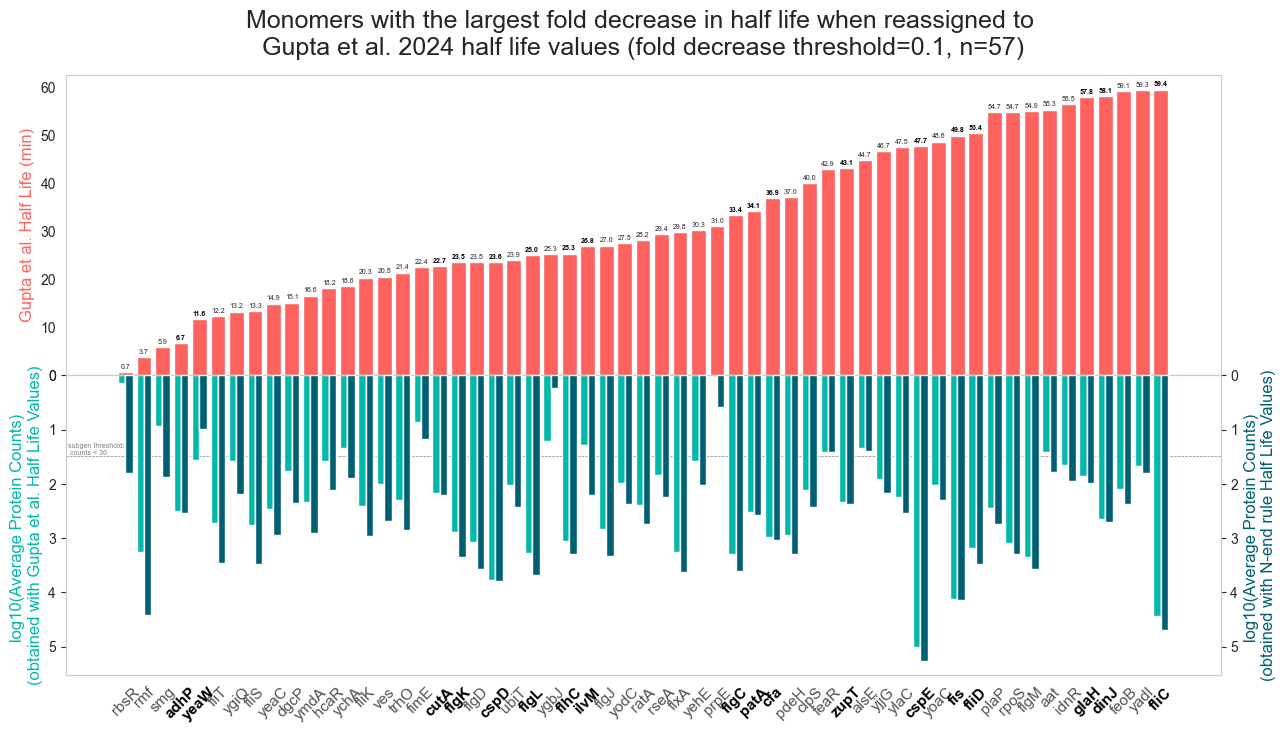

In [300]:
# using this thing: https://sharkcoder.com/data-visualization/mpl-bidirectional


# large increase 
fold_increase_threshold = 30
fold_decrease_threshold = .10

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_large_increase = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()
CLClimNE_large_decrease = CLNE_CLClimNE_log_data_proteases_with_complexes.copy()


# extract the highest fold increase half lives:
CLClimNE_large_increase = CLClimNE_large_increase[CLClimNE_large_increase['HL_fold_change'] >= fold_increase_threshold]
CLClimNE_large_decrease = CLClimNE_large_decrease[CLClimNE_large_decrease['HL_fold_change'] <= fold_decrease_threshold]


CLClimNE_large_decrease.sort_values(by='HL value', ascending=True, inplace=True)



# Specify data to use: 
data_df = CLClimNE_large_decrease
data_df.set_index('common_name', inplace=True)
color_dark_blue = '#005f73'
font_color = '#525252'
hfont = {'fontname':'Calibri'}
color_red = '#fd625e'
color_blue = '#01b8aa'
column0 = data_df['HL value']
column1 = data_df[CLClimNE_new_name]
column2 = data_df[CLNE_new_name]
title0 = f'Monomers with the largest fold decrease in half life when reassigned to \nGupta et al. 2024 half life values (fold decrease threshold={fold_decrease_threshold}, n={len(data_df)})'

fig, axes = plt.subplots(figsize=(15,5),  nrows=2, sharex=True)
fig.tight_layout()

axes[0].bar(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, )
axes[0].set_ylabel('Gupta et al. Half Life (min)', fontsize=12, color=color_red, )
in_complexes = []
for i, val in enumerate(column0):
    complex_type = data_df.at[data_df.index[i], 'complex type']
    if complex_type != 'zero':
        in_complexes.append(data_df.index[i])
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=5, rotation=0, fontweight='bold', color='black')
    else:
        axes[0].text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=5, rotation=0, )


# make it a little fancy (based off this: https://stackoverflow.com/questions/14270391/how-to-plot-multiple-bars-grouped): 
N = len(data_df.index)
ind = np.arange(N)  # the x locations for the groups
width = .4


axes[1].bar(ind-width/2, column1, width, align='center', color=color_blue, zorder=10, )
axes[1].bar(ind+width/2, column2, width, align='center',color=color_dark_blue, zorder=10) # NOTE: this must be plotted. OTHERWISE, the y axis on the reverse side does NOT have the same scale as the left side

# add a likely subgenerational line:
axes[1].axhline(y=np.log10(30+1), color='gray', linestyle='--', linewidth=.5)  
axes[1].text(-3.1, np.log10(30+1), 'subgen threshold:\n counts < 30', ha='left', va='bottom', fontsize=5, color='gray')
axes[1].tick_params(axis='x', labelsize=11)
axes[1].set(xticks=data_df.index, xticklabels=data_df.index)
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
    if tick.get_text() in in_complexes:
        tick.set_fontweight('bold')
        tick.set_color('black')
    else:
        tick.set_fontweight('normal')
        tick.set_color(font_color)

axes[1].invert_yaxis()
axes[1].set_ylabel('log10(Average Protein Counts) \n(obtained with Gupta et al. Half Life Values)', fontsize=12, color=color_blue,)
axes2 = axes[1].twinx()
axes2.bar(ind+width/2, column2, width, align='center',color=color_dark_blue, zorder=10, ) # NOTE: This must be here in order to invert the second y axis counts
axes2.set_ylabel('log10(Average Protein Counts) \n(obtained with N-end rule Half Life Values)', fontsize=12, color=color_dark_blue,)
axes2.invert_yaxis()

# take out the background grid 
axes[0].grid(False)
axes[1].grid(False)
axes2.grid(False)


plt.subplots_adjust(hspace=0, top=1.2, bottom=0, left=0.18, right=0.95)

# save the figure:
out_pth = f"out/figures/{branch_name}/model_output_comparisons/{current_sequence}/monomer_counts_comparison_largest_decrease_in_HL_bar_plot_with_protein_counts_{current_sequence}_vs_{CLNE_sequence}.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')